In [16]:
import sys
sys.path.append('..')

In [17]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from scipy.stats import loguniform
import matplotlib.pyplot as plt

from src.utils import publish_model_scores
from src.datasampling import dataSampling
from src.bayesianopt import bayesianOpt
from src.gridsearch import gridSearch

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import (mutual_info_classif, f_classif, RFE)
from sklearn.metrics import classification_report
from sklearn.preprocessing import (StandardScaler, RobustScaler)
from sklearn.ensemble import (IsolationForest, RandomForestClassifier)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
5   2.0 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   
6   4.0  1.229658  0.141004  0.045371  1.202613  0.191881  0.272708 -0.005159   
7   7.0 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118  1.120631   
8   7.0 -0.894286  0.286157 -0.113192 -0.271526  2.669599  3.721818  0.370145   
9   9.0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761  0.651583   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -

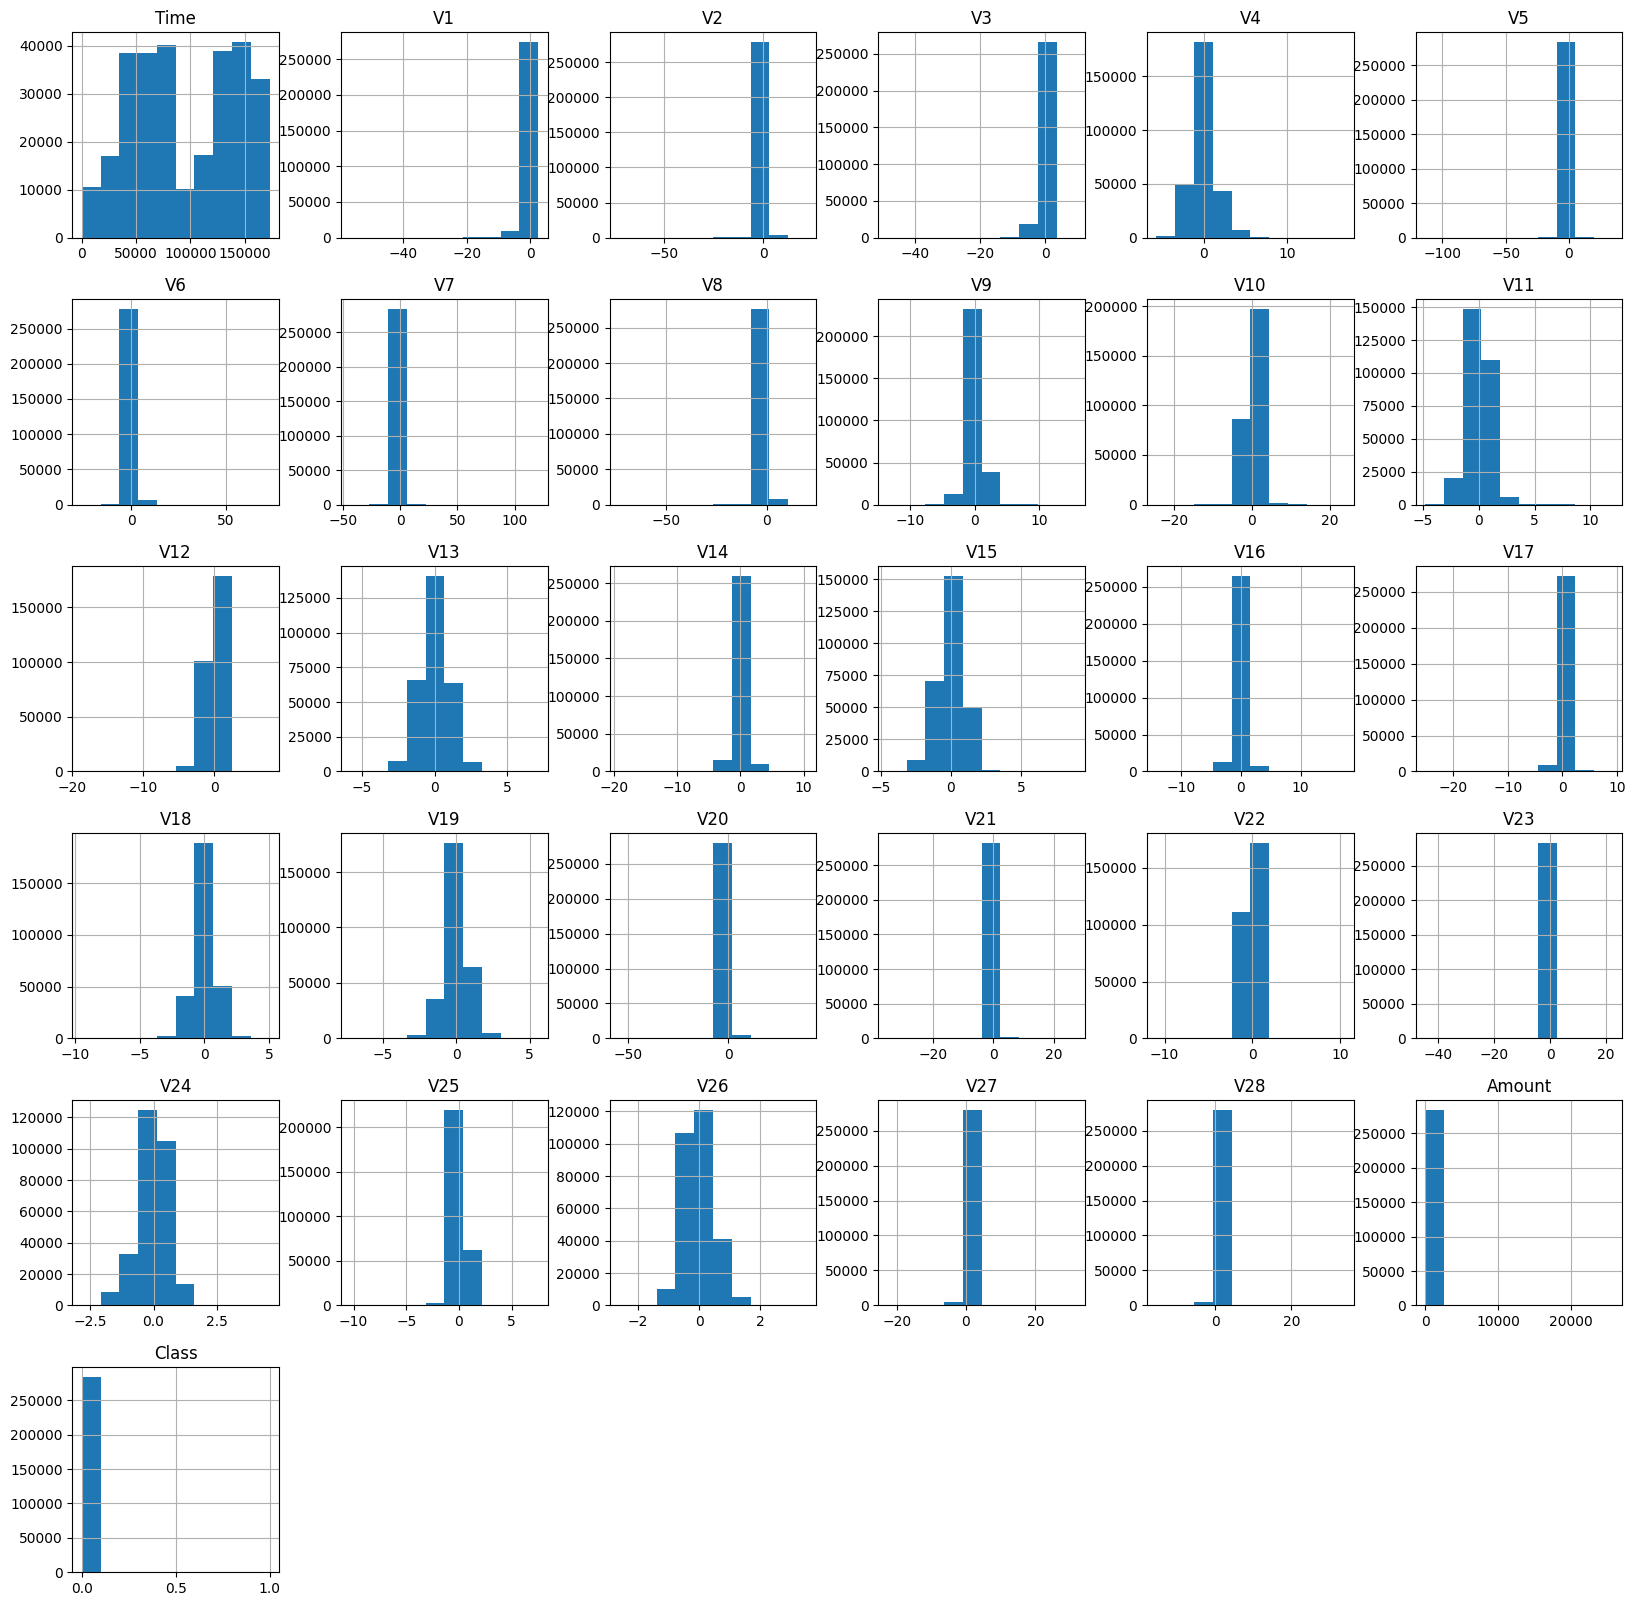

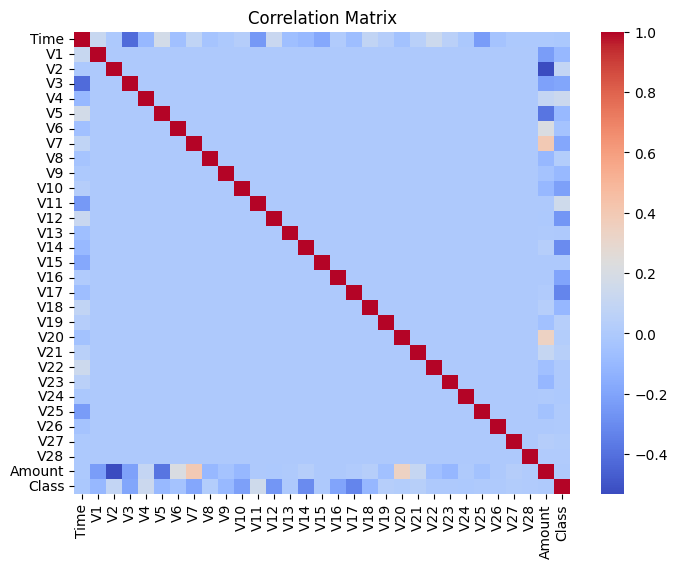

In [18]:
df = pd.read_csv("../creditcard.csv")
print(df.head(n=10))

# Plot the histogrm
df.hist(figsize = (20, 20))
plt.show()

# Comment : features are scaled so need not to do any standard transformation for preprocessing

# Print the correlation of data
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#Comment : There is no significant correlation amoung the data so no need for reducing highly correlated data

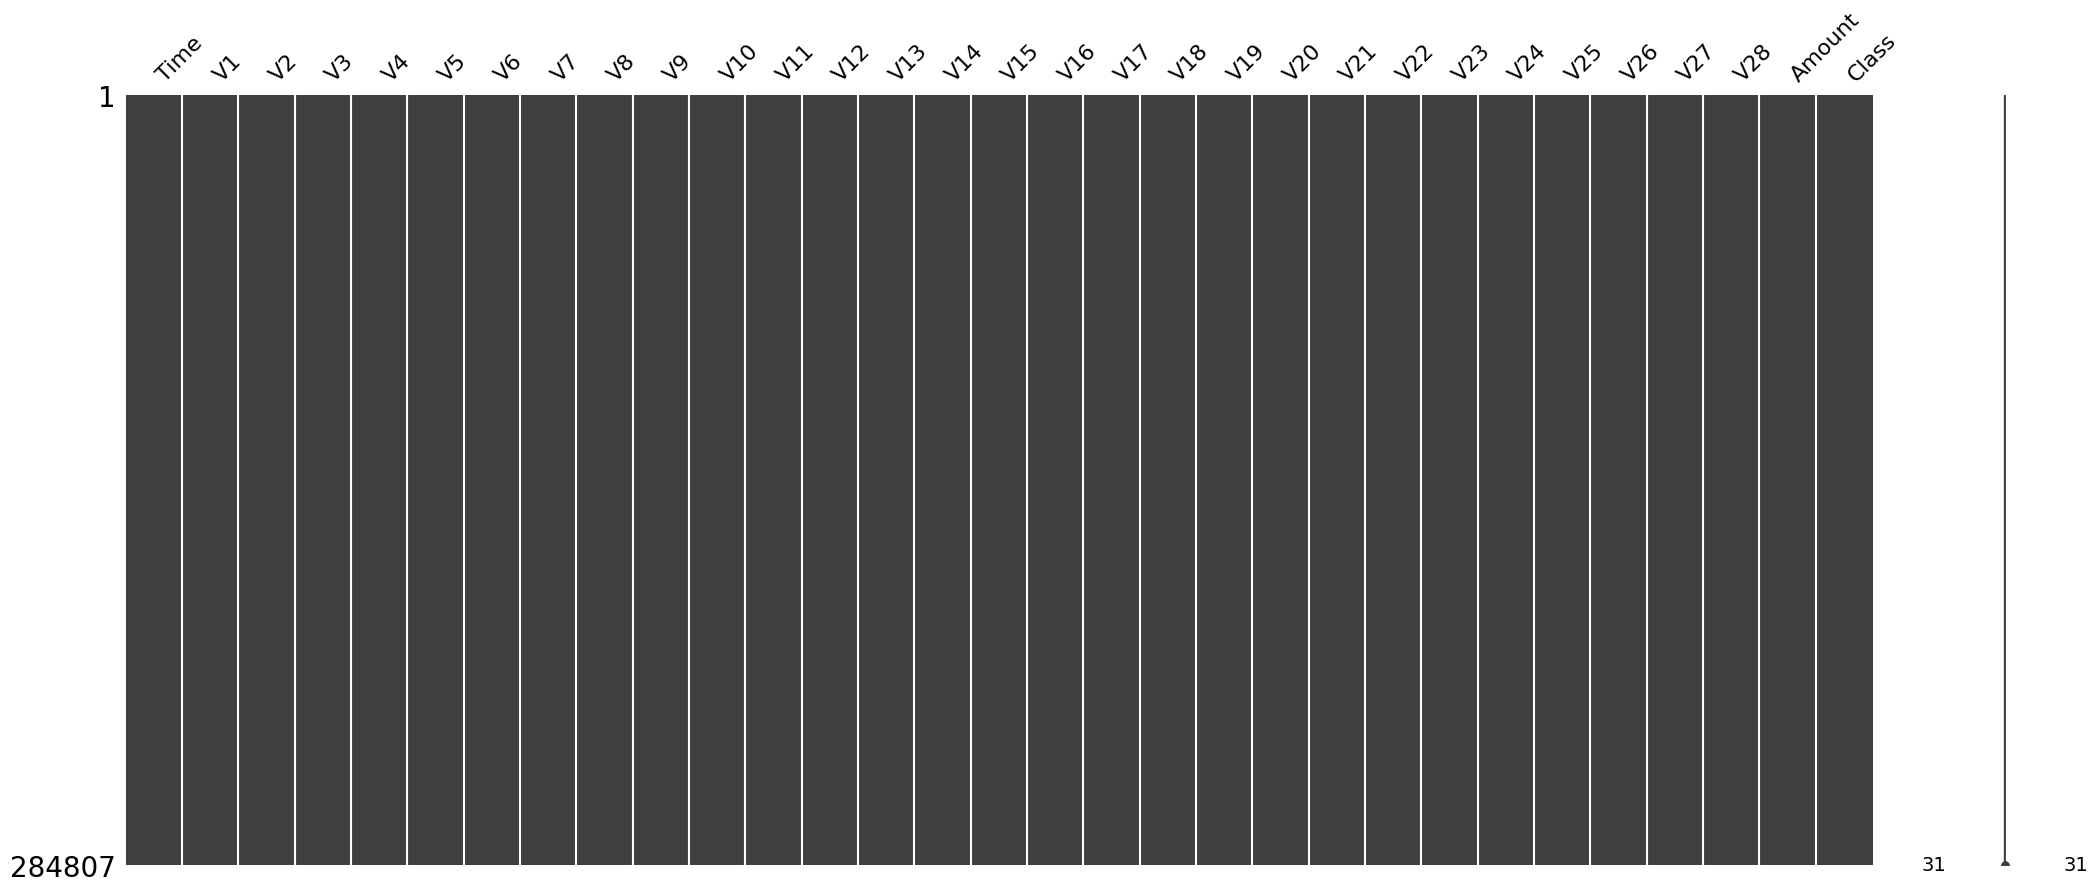

<Figure size 1500x900 with 0 Axes>

In [19]:
# Checking for missing values
msno.matrix(df)
plt.figure(figsize = (15,9))
plt.show()

# ANOMALY DETECTION (via isolation Forests)

In [20]:
X = df.drop(['Class'], axis=1)
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the Isolation Forest model. The contamination parameter should reflect the proportion of fraud cases
iso_forest = IsolationForest(n_estimators=100, contamination=float(np.sum(y == 1)) / len(y))

iso_forest.fit(X_scaled)

# Predict anomalies (1 for inliers, -1 for outliers)
anomalies = iso_forest.predict(X_scaled)

# Convert the predictions to match the 'Class' labels (0 for inliers, 1 for outliers)
anomalies = np.where(anomalies == 1, 0, 1)

df['Anomalies'] = anomalies

In [21]:
print(classification_report(df['Class'], df['Anomalies']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.27      0.27      0.27       492

    accuracy                           1.00    284807
   macro avg       0.64      0.64      0.64    284807
weighted avg       1.00      1.00      1.00    284807



The classification report indicates that:

- The model has perfect precision, recall, and F1-score for the majority class (0), suggesting it identifies non-fraudulent transactions flawlessly.
- The precision, recall, and F1-score for the minority class (1) are all 0.29, indicating that the model is not performing well on the fraudulent transactions. It’s likely that many fraudulent transactions are either not being caught (low recall) or many non-fraudulent transactions are incorrectly being labeled as fraud (low precision).
- The accuracy is perfect, but this is misleading due to the severe class imbalance; the model could be simply predicting everything as the majority class.
- The macro average is 0.64, which isn't high, reflecting the poor performance on the minority class.
- The weighted average F1-score is perfect due to the imbalance heavily weighting the majority class’s performance.

The next steps could involve improving the model’s ability to detect the minority class by trying different models, resampling the data, or using different feature selection methods. It’s also important to focus on metrics beyond accuracy, such as the F1-score or AUC-PR, which are more informative for imbalanced datasets.

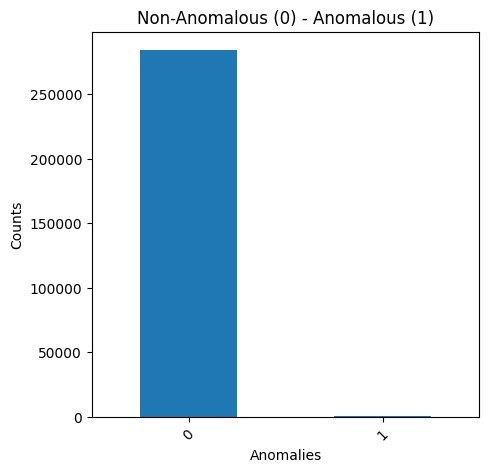

In [22]:
ano = df['Anomalies'].value_counts()

plt.figure(figsize=(5, 5))
ano.plot(kind='bar')
plt.title('Non-Anomalous (0) - Anomalous (1)')
plt.xlabel('Anomalies')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

# FEATURE ENGINEERING

In [23]:
# time based features

def time_to_hour(time_in_seconds):
    return (time_in_seconds // (60 * 60)) % 24

df['HourOfDay'] = df['Time'].apply(time_to_hour)
df['Weekend'] = (df['HourOfDay'] >= 0) & (df['HourOfDay'] < 6)
df['Weekend'] = df['Weekend'].apply(lambda x: 1 if x else 0)

In [24]:
# amount based features

df['Log_Amount'] = np.log(df['Amount'] + 1e-9)  # Adding a small constant to avoid log(0)

# Amount bins
# Define bins for transaction amount
bins = [0, 25, 50, 75, 100, 125, 150, np.inf]
labels = [1, 2, 3, 4, 5, 6, 7]  # These are arbitrary labels for the bins
df['Amount_bin'] = pd.cut(df['Amount'], bins=bins, labels=labels)

In [25]:
# standardization of OG time and amount
scaler = StandardScaler()

df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
df['scaled_HourOfDay'] = scaler.fit_transform(df['HourOfDay'].values.reshape(-1,1))
df['scaled_Log_Amount'] = scaler.fit_transform(df['Log_Amount'].values.reshape(-1,1))
df['scaled_Amount_bin'] = scaler.fit_transform(df['Amount_bin'].values.reshape(-1,1))


df.drop(['Time','Amount', 'HourOfDay', 'Log_Amount', 'Amount_bin'], axis=1, inplace=True)

In [26]:
nan_columns = df.columns[df.isnull().any()]
print(nan_columns)

# Assuming 'df' is your DataFrame and 'column_name' is the name of the column
num_nan_rows = df['scaled_Amount_bin'].isnull().sum()
print(num_nan_rows)

df['scaled_Amount_bin'] = df['scaled_Amount_bin'].fillna(0)

Index(['scaled_Amount_bin'], dtype='object')
1825


# FEATURE SELECTION

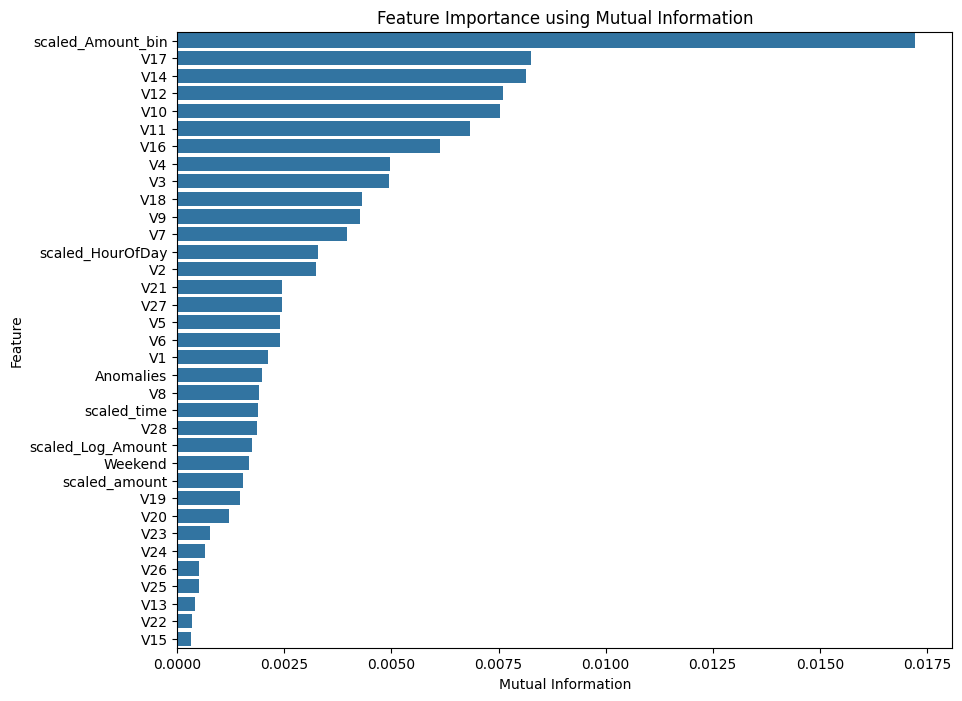

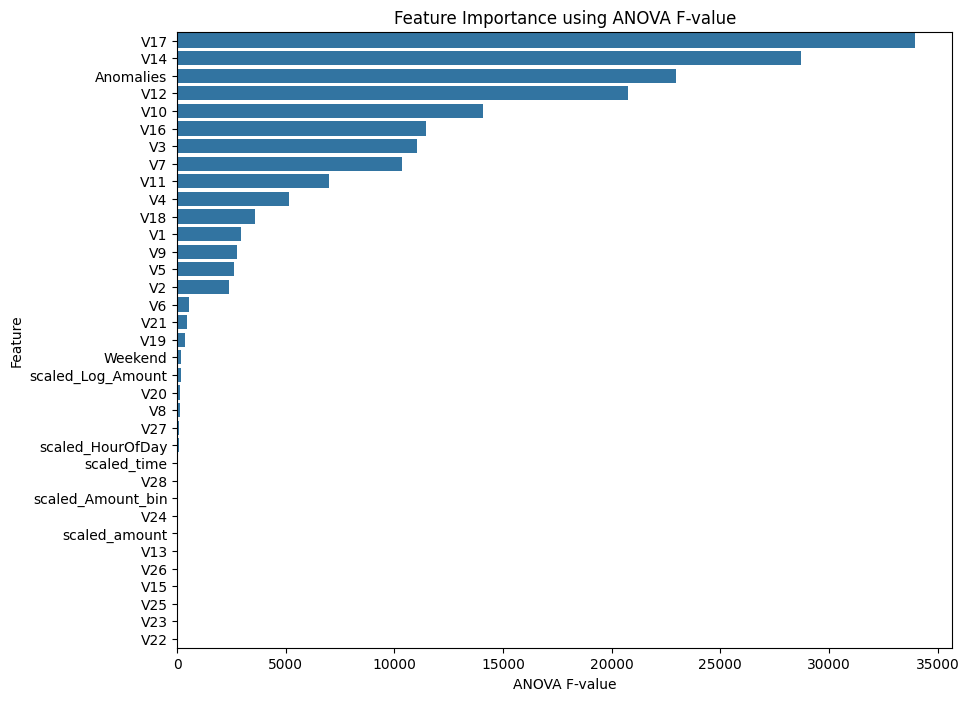

In [27]:
X = df.drop('Class', axis=1)
y = df['Class']

# Calculate mutual information
mi = mutual_info_classif(X, y)
# Calculate ANOVA F-values
f_scores, p_values = f_classif(X, y)

feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi,
    'ANOVA F-value': f_scores,
    'p-value': p_values
})

# Plotting the Mutual Information scores
plt.figure(figsize=(10, 8))
sns.barplot(x='Mutual Information', y='Feature', data=feature_scores.sort_values(by='Mutual Information', ascending=False))
plt.title('Feature Importance using Mutual Information')
plt.show()

# Plotting the ANOVA F-values
plt.figure(figsize=(10, 8))
sns.barplot(x='ANOVA F-value', y='Feature', data=feature_scores.sort_values(by='ANOVA F-value', ascending=False))
plt.title('Feature Importance using ANOVA F-value')
plt.show()

In [28]:
anova_threshold = 1000  

# Identify features that fall below this threshold
features_to_remove = feature_scores[feature_scores['ANOVA F-value'] < anova_threshold]['Feature'].tolist()
print(features_to_remove)

df = df.drop(columns=features_to_remove)
print(df.head())
print(df.info())
print("If anyy null value present in the data:",df.isnull().values.any())

['V6', 'V8', 'V13', 'V15', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Weekend', 'scaled_amount', 'scaled_time', 'scaled_HourOfDay', 'scaled_Log_Amount', 'scaled_Amount_bin']
         V1        V2        V3        V4        V5        V7        V9  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.239599  0.363787   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.078803 -0.255425   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  0.791461 -1.514654   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  0.237609 -1.387024   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.592941  0.817739   

        V10       V11       V12       V14       V16       V17       V18  \
0  0.090794 -0.551600 -0.617801 -0.311169 -0.470401  0.207971  0.025791   
1 -0.166974  1.612727  1.065235 -0.143772  0.463917 -0.114805 -0.183361   
2  0.207643  0.624501  0.066084 -0.165946 -2.890083  1.109969 -0.121359   
3 -0.054952 -0.226487  0.178228 -0.287924 -1.05

# 1 Evaluate Gradient Boosting Tree Classifier without sampling techniques

# 1.1 Get the data

In [29]:
# Make a data source object using dataSampling class
ds = dataSampling(df,"Class",0.30,42,True,True)

In [30]:
# Make in-smaple and out sample dataset without sampling
X_train,X_test,y_train,y_test = ds.get_data_without_sample()
ds.print_class_percentage(X_train,X_test,y_train,y_test)

=====Train class count=====
Class
0    199020
1       344
Name: count, dtype: int64
Class
0    0.998275
1    0.001725
Name: count, dtype: float64

=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 1.2 Fit the Descion Tree Classifier and optimize Hyperparameters using Bayesian Optimization

In [33]:
# Specified the parameters
param_grid ={
    "max_iter": [3, 10, 30, 100, 300, 1000],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
    "cv":[5],"scoring":["f1_macro"],"n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":5}

# Fit and Optimize the Baysian model
dt_opt = bayesianOpt(GradientBoostingClassifier(random_state=0))
best_model = dt_opt.optimize_fit(X_train,y_train,param_grid,conf_dict)

Best score: 0.883621838243787: 100%|██████████| 5/5 [57:15<00:00, 687.02s/it]


# 1.3 See the performance on unseen data

In [34]:
dt_opt.optimize_results["best_params"]

{'cv': 5,
 'learning_rate': 0.014106228596000659,
 'max_iter': 300,
 'max_leaf_nodes': 50,
 'n_jobs': -1,
 'scoring': 'f1_macro'}

In [35]:
print("------Training model Results------")
publish_model_scores(X_train,y_train,best_model)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_model)

------Training model Results------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.94      0.73      0.82       344

    accuracy                           1.00    199364
   macro avg       0.97      0.86      0.91    199364
weighted avg       1.00      1.00      1.00    199364

ROC_AUC Score 0.9527005364074662
Confusion Matrix [[199005     15]
 [    94    250]]
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.91      0.70      0.79       148

    accuracy                           1.00     85443
   macro avg       0.96      0.85      0.90     85443
weighted avg       1.00      1.00      1.00     85443

ROC_AUC Score 0.925158670306393
Confusion Matrix [[85285    10]
 [   44   104]]


{'Recall': 0.7027027027027027,
 'Precision': 0.9122807017543859,
 'f1': 0.7938931297709922,
 'accuracy': 0.9993679997191109,
 'roc_auc': 0.925158670306393}

# 2. Evaluate using under sampling (near miss) method

# 2.1 Get the data

In [36]:
X_nm_train,X_test,y_nm_train,y_test= ds.get_data_near_miss()
ds.print_class_percentage(X_nm_train,X_test,y_nm_train,y_test)

=====Train class count=====
Class
0    3440
1     344
Name: count, dtype: int64
Class
0    0.909091
1    0.090909
Name: count, dtype: float64

=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 2.2 Fit the Descion Tree Classifier and optimize Hyperparameters using Bayesian Optimization

In [37]:
# Specified the parameters
param_grid ={
    "max_iter": [3, 10, 30, 100, 300, 1000],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
    "cv":[5],"scoring":["f1_macro"],"n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":5}

# Fit and Optimize the Baysian model
dt_nm_opt = bayesianOpt(GradientBoostingClassifier(random_state=0))
best_nm_model = dt_nm_opt.optimize_fit(X_nm_train,y_nm_train,param_grid,conf_dict)

Best score: 0.960983347918052: 100%|██████████| 5/5 [01:00<00:00, 12.09s/it]


# 2.3 See the performance on unseen data

In [38]:
dt_nm_opt.optimize_results["best_params"]

{'cv': 5,
 'learning_rate': 0.06710639195258596,
 'max_iter': 1000,
 'max_leaf_nodes': 50,
 'n_jobs': -1,
 'scoring': 'f1_macro'}

In [39]:
print("------Training model Results------")
publish_model_scores(X_nm_train,y_nm_train,best_nm_model)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_nm_model)

------Training model Results------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3440
           1       0.99      0.96      0.97       344

    accuracy                           1.00      3784
   macro avg       0.99      0.98      0.99      3784
weighted avg       1.00      1.00      1.00      3784

ROC_AUC Score 0.9958415021633314
Confusion Matrix [[3438    2]
 [  15  329]]
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      0.69      0.82     85295
           1       0.01      0.92      0.01       148

    accuracy                           0.69     85443
   macro avg       0.50      0.81      0.41     85443
weighted avg       1.00      0.69      0.82     85443

ROC_AUC Score 0.9079674199083307
Confusion Matrix [[59234 26061]
 [   12   136]]


{'Recall': 0.918918918918919,
 'Precision': 0.005191434133679429,
 'f1': 0.010324539760865439,
 'accuracy': 0.6948491977107545,
 'roc_auc': 0.9079674199083307}

# 3. Evaluate using under sampling (SMOTE) method
# 3.1 Get the data sets using SMOTE sampling technique

In [112]:
X_sm_train,X_test,y_sm_train,y_test= ds.get_data_smote()
ds.print_class_percentage(X_sm_train,X_test,y_sm_train,y_test)

=====Train class count=====
Class
0    199020
1    199020
Name: count, dtype: int64
Class
0    0.5
1    0.5
Name: count, dtype: float64

=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 3.2 Fit the data and tune the hyperparametres using Bayesian Optimization

In [113]:
# Specified the parameters
param_grid = { 'criterion':['gini','entropy'],
              'max_depth': np.arange(1,15),
              "max_features": ['sqrt', 'log2'],
              "min_samples_split": range(2,21),
              "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
              "cv":[5],"scoring":["f1_macro"],"n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":100}

# Fit and Optimize the Baysian model
dt_sm_opt = bayesianOpt(DecisionTreeClassifier(random_state = 0))
best_sm_model = dt_sm_opt.optimize_fit(X_sm_train,y_sm_train,param_grid,conf_dict)

Best score: 0.9889355314307113: 100%|██████████| 100/100 [14:19<00:00,  8.60s/it]


# 3.3 Evaluate the Performance

In [114]:
print("------Training model Results------")
publish_model_scores(X_sm_train,y_sm_train,best_sm_model)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_sm_model)

------Training model Results------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    199020
           1       0.98      0.99      0.99    199020

    accuracy                           0.99    398040
   macro avg       0.99      0.99      0.99    398040
weighted avg       0.99      0.99      0.99    398040

ROC_AUC Score 0.9990807304929922
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.85      0.11       148

    accuracy                           0.98     85443
   macro avg       0.53      0.91      0.55     85443
weighted avg       1.00      0.98      0.99     85443

ROC_AUC Score 0.9252571758111356


# 4 Evaluate Performance using Random Over Sampling Methods
# 4.1 Get the dataset using ramdom over sampling method

In [115]:
X_rn_train,X_test,y_rn_train,y_test= ds.get_data_random_over_sample()
ds.print_class_percentage(X_rn_train,X_test,y_rn_train,y_test)

=====Train class count=====
Class
0    199020
1    199020
Name: count, dtype: int64
Class
0    0.5
1    0.5
Name: count, dtype: float64

=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 4.2 Fit the data and tune the hyperparametres using Bayesian Optimization

In [116]:
# Specified the parameters
param_grid = { 'criterion':['gini','entropy'],
              'max_depth': np.arange(1,15),
              "max_features": ['sqrt', 'log2'],
              "min_samples_split": range(2,21),
              "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
              "cv":[5],"scoring":["f1_macro"],"n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":100}

# Fit and Optimize the Baysian model
dt_rn_opt = bayesianOpt(DecisionTreeClassifier(random_state = 0))
best_rn_model = dt_rn_opt.optimize_fit(X_rn_train,y_rn_train,param_grid,conf_dict)

Best score: 0.9966937565163377: 100%|██████████| 100/100 [07:38<00:00,  4.59s/it]


# 4.3 Evaluate the Performance on unseen data

In [117]:
print("------Training model Results------")
publish_model_scores(X_rn_train,y_rn_train,best_rn_model)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_rn_model)

------Training model Results------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       1.00      1.00      1.00    199020

    accuracy                           1.00    398040
   macro avg       1.00      1.00      1.00    398040
weighted avg       1.00      1.00      1.00    398040

ROC_AUC Score 0.9998876377224988
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.23      0.80      0.36       148

    accuracy                           1.00     85443
   macro avg       0.62      0.90      0.68     85443
weighted avg       1.00      1.00      1.00     85443

ROC_AUC Score 0.8980500504608014


# Performance Evaluation with Grid Search CV

In [124]:
import time

In [125]:
ITER = 5

In [126]:
# Specified the parameters
param_grid = { 'criterion':['gini','entropy'],
              'max_depth': np.arange(1,15),
              "max_features": ['sqrt', 'log2'],
              "min_samples_split": range(2,21),
              "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
              "cv":[5],"scoring":["f1_macro"],"n_jobs":[-1]}

# Fit and Optimize the Baysian model
start_gs = time.time()
for i in range(ITER):
    dt_nm_srch = gridSearch(DecisionTreeClassifier(random_state = 0))
    best_nm_model_gs = dt_nm_srch.optimize_fit(X_nm_train,y_nm_train,param_grid)
end_gs = time.time()
compute_time_gs = end_gs - start_gs

In [127]:
print("----------Best Parameters---------")
print(dt_nm_srch.results["best_params_"])
print("------Training model Results------")
publish_model_scores(X_nm_train,y_nm_train,best_nm_model_gs)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_nm_model_gs)
print("---------Average Time to take the model----------------")
print(compute_time_gs/ITER)

----------Best Parameters---------
{'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 13, 'max_features': 'sqrt', 'min_samples_split': 7}
------Training model Results------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3440
           1       0.99      0.96      0.98       344

    accuracy                           1.00      3784
   macro avg       0.99      0.98      0.99      3784
weighted avg       1.00      1.00      1.00      3784

ROC_AUC Score 0.998789463899405
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      0.53      0.69     85295
           1       0.00      0.96      0.01       148

    accuracy                           0.53     85443
   macro avg       0.50      0.74      0.35     85443
weighted avg       1.00      0.53      0.69     85443

ROC_AUC Score 0.7499296559001115
---------Average Time to take the model---------------

In [128]:
# Specified the parameters
param_grid = { 'criterion':['gini','entropy'],
              'max_depth': np.arange(1,15),
              "max_features": ['sqrt', 'log2'],
              "min_samples_split": range(2,21),
              "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
              "cv":[5],"scoring":["f1_macro"],"n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":100}

# Fit and Optimize the Baysian model
start_bays = time.time()
for i in range(ITER):
    dt_nm_opt = bayesianOpt(DecisionTreeClassifier(random_state = 0))
    best_nm_model_bays = dt_nm_opt.optimize_fit(X_nm_train,y_nm_train,param_grid,conf_dict)
end_bays = time.time()
compute_time_bays = end_bays - start_bays

Best score: 0.9645951777674888: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


In [129]:
print("----------Best Parameters---------")
print(dt_nm_opt.optimize_results["best_params"])
print("------Training model Results------")
publish_model_scores(X_nm_train,y_nm_train,best_nm_model_bays)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_nm_model_bays)
print("---------Time to take----------------")
print(compute_time_bays/ITER)

----------Best Parameters---------
{'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'cv': 5, 'max_depth': 14, 'max_features': 'log2', 'min_samples_split': 12, 'n_jobs': -1, 'scoring': 'f1_macro'}
------Training model Results------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3440
           1       0.99      0.97      0.98       344

    accuracy                           1.00      3784
   macro avg       1.00      0.98      0.99      3784
weighted avg       1.00      1.00      1.00      3784

ROC_AUC Score 0.9997790190643591
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      0.64      0.78     85295
           1       0.00      0.95      0.01       148

    accuracy                           0.64     85443
   macro avg       0.50      0.79      0.39     85443
weighted avg       1.00      0.64      0.78     85443

ROC_AUC Score 0.8166101194106938
------

# SHAP ANALYSIS

In [45]:
import shap

explainer = shap.Explainer(best_model)

shap_values = explainer(X_train)

# Indexing for the positive class SHAP values (which is typically at index 1)
positive_class_shap_values = shap_values #[..., 1]

In [46]:
print(shap_values.shape)

(199364, 15, 2)


In [51]:
# Plot the SHAP values for the first instance's positive class
shap.plots.waterfall(shap_values[0,0])

TypeError: only size-1 arrays can be converted to Python scalars

In [44]:
positive_class_shap_values[0]

.values =
array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.34770274e-04, -1.34770190e-04],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 1.06419325e-04, -1.06420535e-04],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [-4.59963083e-05,  4.59962105e-05],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00]])

.base_values =
array([9.99778676e-01, 2.21324302e-04])

.data =
array([ 0.        , -0.28912741, -0.33308724,  0.64121874, -1.3367637 ,
        0.76810007,  0.83101743,  0.4990415 , -1.51894032,  1.36646016,
       -1.49483245, -0.73767121,  0.45768976, -0.31029064,  0.43879152])

In [42]:
shap.plots.waterfall(shap_values[0])

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (15, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [43]:
shap.plots.waterfall(shap_values[0, 0])

TypeError: only size-1 arrays can be converted to Python scalars

In [52]:
shap.plots.bar(shap_values)

IndexError: list index out of range

TypeError: only integer scalar arrays can be converted to a scalar index

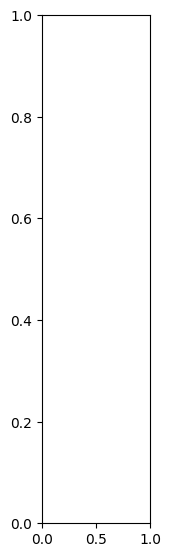

In [53]:
shap.summary_plot(shap_values, X_train)